In [ ]:
#Needed imports
#you might to install these libraries:
%pip install pretty_midi
%pip install librosa
%pip install pyfluidsynth  

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 5.6/5.6 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 51.1/51.1 kB 2.6 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592308 sha256=90e08a3306e1cf44b08c7af6932d3bff1fdd2b2d86cdc5bee877e713c93197ca
  Stored in directory: c:\users\罗晓珂\appdata\local\pip\cache\wheels\10\01\43\0f51560a828b53208b0c6887578a35e0872b18c4fb498b556b
Successfully built pretty_midi
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
Note: you may need to restart the k

In [175]:
import sys
import numpy as np
import librosa, pretty_midi
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import os
import librosa.display
from librosa import util

In [177]:
score_midi = "D:/罗晓珂/Documents/Music-Score Alignment/midi/Chopin_Ballade/Chopin_op38_p01.mid"
perf = "D:/罗晓珂/Documents/Music-Score Alignment/audio/Chopin_Ballade/Chopin_op38_p01"
fs = 44100
stride = 512
n_fft = 4096

n_mels = 138
# onset-detect的参数
fmin = 27.5
fmax = 16000.
lag = 2
max_size = 3

In [36]:
"""
使用librosa.sequence.dtw方法实现DTW
使用的feature为chroma
"""
# 以MIDI形式获取score
score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
# 获取表演音频
perf,_ = librosa.load(perf + '.wav', sr=fs) 
# 把score和表演都转换为chroma feature
score_chroma = librosa.feature.chroma_stft(y=score_synth, sr=fs, tuning=0, norm=2,
                                           hop_length=stride, n_fft=n_fft)
score_logch = librosa.power_to_db(score_chroma, ref=score_chroma.max())
perf_chroma = librosa.feature.chroma_stft(y=perf, sr=fs, tuning=0, norm=2,
                                          hop_length=stride, n_fft=n_fft)
perf_logch = librosa.power_to_db(perf_chroma, ref=perf_chroma.max())

# 运行DTW
# D is COST matrix
D, wp = librosa.sequence.dtw(X=score_logch, Y=perf_logch)
path = np.array(list(reversed(np.asarray(wp))))

In [179]:
"""对MIDI以及audio使用superflux得到的onset_envelope特征作为特征输入
为了鲁棒性，要对两者的特征进行归一化"""
# 以MIDI形式获取score
score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
# 获取表演音频
perf,_ = librosa.load(perf + '.wav', sr=fs) 
# 把score和表演都转换为spectral flux feature
score_S = librosa.feature.melspectrogram(y=score_synth, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
score_env = librosa.onset.onset_strength(S=librosa.power_to_db(score_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)
perf_S = librosa.feature.melspectrogram(y=perf, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
perf_env = librosa.onset.onset_strength(S=librosa.power_to_db(perf_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)


In [40]:
score_env.size

11437

In [41]:
perf_env.size

11043

In [180]:
"""参照librosa的方法对envolope进行归一化"""
def nrm_onset_env(onset_envelope):
    onset_envelope = onset_envelope - np.min(onset_envelope)

    # Mypy does not realize that oenv is not None by now
    # Max-scale with safe division
    onset_envelope /= np.max(onset_envelope) + util.tiny(onset_envelope)  # type: ignore
    return onset_envelope

In [181]:
score_env_norm = nrm_onset_env(score_env)
perf_env_norm = nrm_onset_env(perf_env)

In [44]:
score_env_norm

array([0.06691425, 0.06691425, 0.06691425, ..., 0.06371142, 0.06374345,
       0.06377515])

In [45]:
perf_env_norm

array([0.04844863, 0.04844863, 0.04844863, ..., 0.04930391, 0.04235726,
       0.04505582])

In [46]:
score_onset = librosa.onset.onset_detect(onset_envelope=score_env,
                                      sr=fs,
                                      hop_length=stride,
                                      units='time')
perf_onset = librosa.onset.onset_detect(onset_envelope=perf_env,
                                      sr=fs,
                                      hop_length=stride,
                                      units='time')

In [47]:
score_onset

array([  5.59600907,   6.06040816,   6.81505669,   7.20979592,
         7.95283447,   8.38240363,   9.20671202,   9.74077098,
        10.4954195 ,  10.97142857,  11.7260771 ,  12.24852608,
        12.86385488,  13.03800454,  13.57206349,  14.3847619 ,
        14.86077098,  15.69668934,  16.17269841,  16.97378685,
        17.54267574,  18.40181406,  18.97070295,  19.74857143,
        20.20136054,  20.97922902,  21.40879819,  22.16344671,
        22.66267574,  23.23156463,  23.39410431,  23.83528345,
        24.63637188,  25.15882086,  25.71609977,  25.91346939,
        26.44752834,  27.29505669,  27.84072562,  28.66503401,
        29.22231293,  30.01179138,  30.4645805 ,  31.19600907,
        31.63718821,  32.38022676,  32.89106576,  33.47156463,
        33.62249433,  34.11011338,  34.87637188,  35.35238095,
        36.15346939,  36.64108844,  37.46539683,  37.97623583,
        38.8121542 ,  39.34621315,  40.18213152,  40.63492063,
        41.40117914,  41.81913832,  42.58539683,  43.06

In [29]:
perf_onset

array([ 1.14938776,  1.40480726,  1.46285714,  1.6370068 ,  1.7414966 ,
        2.05496599,  2.08979592,  2.27555556,  2.44970522,  2.6122449 ,
        2.82122449,  2.96054422,  3.09986395,  3.15791383,  3.39011338,
        3.55265306,  3.58748299,  3.66875283,  3.71519274,  3.87773243,
        4.05188209,  4.20281179,  4.40018141,  4.44662132,  4.56272109,
        4.62077098,  4.74848073,  4.95746032,  5.07356009,  5.20126984,
        5.24770975,  5.39863946,  5.54956916,  5.78176871,  5.97913832,
        6.2461678 ,  6.30421769,  6.62929705,  6.82666667,  7.00081633,
        7.15174603,  7.23301587,  7.32589569,  7.50004535,  7.56970522,
        7.69741497,  7.74385488,  7.83673469,  7.8831746 ,  8.05732426,
        8.2430839 ,  8.27791383,  8.39401361,  8.57977324,  8.62621315,
        8.7539229 ,  8.81197279,  8.91646259,  9.09061224,  9.14866213,
        9.27637188,  9.32281179,  9.40408163,  9.64789116, 10.11229025,
       10.44897959, 10.54185941, 10.66956916, 10.83210884, 11.01

In [51]:
# 将onset_env作为输入
D, wp = librosa.sequence.dtw(X=perf_env_norm, Y=score_env_norm)
path = np.array(list(reversed(np.asarray(wp))))

In [49]:
path

array([[    0,     0],
       [    1,     1],
       [    2,     2],
       ...,
       [11040, 11434],
       [11041, 11435],
       [11042, 11436]])

In [50]:
path

array([[    0,     0],
       [    1,     1],
       [    2,     2],
       ...,
       [11040, 11434],
       [11041, 11435],
       [11042, 11436]])

<Figure size 2400x800 with 0 Axes>

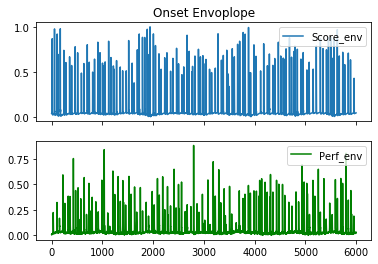

In [190]:
plt.figure(figsize=(30, 10), dpi=80)
fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(score_env_norm[1000:7000], label='Score_env')
# ax[0].vlines(score_onset, 0, score_env_norm.max(), color='r', label='Score_Onsets')
ax[0].legend()
ax[0].label_outer()

ax[1].plot(perf_env_norm[1000:7000], color='g', label='Perf_env')
# ax[1].vlines(perf_onset, 0, perf_env_norm.max(), color='r', label='Perf_Onsets')
ax[1].legend()
ax[0].label_outer()
ax[0].set_title("Onset Envoplope")
plt.show()


In [120]:
"""
对MIDI以及audio使用superflux得到的onset_envelope特征作为特征输入
为了鲁棒性，要对两者的特征进行归一化

"""
def align_flux(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    # 以MIDI形式获取score
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    # 获取表演音频
    perf,_ = librosa.load(perf + '.wav', sr=fs) 
    # 把score和表演都转换为spectral flux feature
    score_S = librosa.feature.melspectrogram(y=score_synth, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
    score_env = librosa.onset.onset_strength(S=librosa.power_to_db(score_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)
    perf_S = librosa.feature.melspectrogram(y=perf, sr=fs, n_fft=n_fft,
                                   hop_length=stride,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)
    perf_env = librosa.onset.onset_strength(S=librosa.power_to_db(perf_S, ref=np.max),
                                      sr=fs,
                                      hop_length=stride,
                                      lag=lag, max_size=max_size, detrend = True)
    score_env_norm = nrm_onset_env(score_env)
    perf_env_norm = nrm_onset_env(perf_env)
    
    D, wp = librosa.sequence.dtw(X=perf_env_norm, Y=score_env_norm)
    path = np.array(list(reversed(np.asarray(wp))))

    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)

"""
This function aligns the chroma features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_chroma(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    # 以MIDI形式获取score
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    perf,_ = librosa.load(perf + '.wav', sr=fs) # 获取表演音频
    # 把score和表演都转换为chroma feature
    score_chroma = librosa.feature.chroma_stft(y=score_synth, sr=fs, tuning=0, norm=2,
                                               hop_length=stride, n_fft=n_fft)
    score_logch = librosa.power_to_db(score_chroma, ref=score_chroma.max())
    perf_chroma = librosa.feature.chroma_stft(y=perf, sr=fs, tuning=0, norm=2,
                                              hop_length=stride, n_fft=n_fft)
    perf_logch = librosa.power_to_db(perf_chroma, ref=perf_chroma.max())
    D, wp = librosa.sequence.dtw(X=score_logch, Y=perf_logch)
    path = np.array(list(reversed(np.asarray(wp))))

    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)

"""
This function aligns the spectrogram features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_spectra(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    perf,_ = librosa.load(perf + '.wav', sr=fs)
    score_spec = np.abs(librosa.stft(y=score_synth, hop_length=stride, n_fft=n_fft))**2
    score_logspec = librosa.power_to_db(score_spec, ref=score_spec.max())
    perf_spec = np.abs(librosa.stft(y=perf, hop_length=stride, n_fft=n_fft))**2
    perf_logspec = librosa.power_to_db(perf_spec, ref=perf_spec.max())
    D, wp = librosa.sequence.dtw(X=score_logspec, Y=perf_logspec)
    # D is COST matrix
    path = np.array(list(reversed(np.asarray(wp))))
    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)

#sort of wrapper function
def align_all(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    align1=align_chroma(score_midi, perf, fs, stride, n_fft)
    align2=align_spectra(score_midi, perf, fs, stride, n_fft)
    align3=align_flux(score_midi, perf, fs, stride, n_fft)
    return align1,align2,align3 #later on we'll save these alignments in a file

In [121]:
muiñeira_path = "D:/罗晓珂/Documents/Music-Score Alignment/"
alignment_path = "D:/罗晓珂/Documents/Music-Score Alignment/alignments/"

In [130]:
path = alignment_path+'alignments{idx}'.format(idx=1)
path

'D:/罗晓珂/Documents/Music-Score Alignment/alignments/alignments1'

In [89]:
perf_path=muiñeira_path+'audio/Chopin_Ballade/'

In [73]:
perf_wav=[f for f in os.listdir(perf_path) if f.endswith('.wav')]

In [77]:
perf_wav[0]

'Chopin_op38_p01.wav'

In [131]:
def align_chopin(muiñeira_path,alignment_path):
    try:
#         os.mkdir(muiñeira_path+'/alignments')
        
        #access the score and performance of the first muiñeira
        score_path=muiñeira_path+'midi/Chopin_Ballade/'
        perf_path=muiñeira_path+'audio/Chopin_Ballade/'
        #get wav file in performance folder
        perf_wavs=[f for f in os.listdir(perf_path) if f.endswith('.wav')]
        #get midi file in score folder
        score_midis=[f for f in os.listdir(score_path) if f.endswith('.mid')]
        for idx,perf_wav in enumerate(perf_wavs):
            #align the score and performance
            align1,align2,align3 = align_all(score_path+'/'+score_midis[idx], perf_path+'/'+perf_wav[:-4])
            #save first alignment in text file, row1 is time in score, row2 is time in performance
            #add a header to the file
            header='score_time, perf_time'
            #create new folder in muiñeira_path called 'alignments'
            #save the alignment in the new folder
            os.mkdir(alignment_path+'/alignments{idx}'.format(idx=idx))
            path = alignment_path+'alignments{idx}'.format(idx=idx)
            print("Create alignment folder{idx}".format(idx=idx))
            np.savetxt(path+'/align_chroma.txt', align1, delimiter=',', header=header)
            #save second alignment in text file, row1 is time in score, row2 is time in performance
            np.savetxt(path+'/align_spectra.txt', align2, delimiter=',', header=header)
            np.savetxt(path+'/align_flux.txt', align3, delimiter=',', header=header)
    except Exception as e:
        print(e)

In [132]:
align_chopin(muiñeira_path,alignment_path)

Create alignment folder0
Create alignment folder1
Create alignment folder2
Create alignment folder3
Create alignment folder4
Create alignment folder5
Create alignment folder6
Create alignment folder7
Create alignment folder8
Create alignment folder9
Create alignment folder10
Create alignment folder11


KeyboardInterrupt: 

In [112]:
import pandas as pd
import numpy as np
align_chroma_fonsagrada = alignment_path+'/align_flux.txt'
df = pd.read_csv(align_chroma_fonsagrada, sep = ",", names=['score_time', 'perf_time'], header=0)
display(df)

,score_time,perf_time
0,0.00000,0.000000
1,0.01161,0.011610
2,0.02322,0.023220
3,0.03483,0.034830
4,0.04644,0.046440
...,...,...
11038,128.15093,131.970612
11039,128.16254,132.736871
11040,128.17415,132.748481
11041,128.18576,132.760091


In [113]:
my_rho = np.corrcoef(df['score_time'],df['perf_time'])
my_rho

array([[1.        , 0.99994564],
       [0.99994564, 1.        ]])

In [114]:
# 计算皮尔森系数
coef_corr = df["score_time"].corr(df["perf_time"], method="pearson")
coef_corr

0.9999456374229408

In [134]:
list_alignments = [f for f in os.listdir(alignment_path)]
list_alignments

['alignments0',
 'alignments1',
 'alignments10',
 'alignments11',
 'alignments2',
 'alignments22',
 'alignments3',
 'alignments4',
 'alignments5',
 'alignments6',
 'alignments7',
 'alignments8',
 'alignments9']

In [138]:
files = os.listdir(alignment_path+list_alignments[0])
files

['align_chroma.txt', 'align_flux.txt', 'align_spectra.txt']

In [150]:
coef_corr_chroma = pd.DataFrame(columns=['txt','coef_corr_chroma'])
coef_corr_spectra = pd.DataFrame(columns=['txt','coef_corr_spectra'])
coef_corr_flux = pd.DataFrame(columns=['txt','coef_corr_flux'])
for alignments in list_alignments:
    #print(alignments)
    files = os.listdir(alignment_path+alignments)
    #print(txt)
    txts=[]
    txts.append(os.path.join(alignment_path+alignments,files[0]))
    txts.append(os.path.join(alignment_path+alignments,files[1]))
    txts.append(os.path.join(alignment_path+alignments,files[2]))
    for txt in txts:
        if 'chroma' in txt:
            df = pd.read_csv(txt, sep = ",", names=['score_time', 'perf_time'], header=0)
            coef_corr = df["score_time"].corr(df["perf_time"], method="pearson")
            coef_corr_chroma = coef_corr_chroma.append({'txt': alignments, 'coef_corr_chroma': coef_corr}, ignore_index=True)

        if 'spectra' in txt:
            df = pd.read_csv(txt, sep = ",", names=['score_time', 'perf_time'], header=0)
            coef_corr = df["score_time"].corr(df["perf_time"], method="pearson")
            coef_corr_spectra = coef_corr_spectra.append({'txt': alignments, 'coef_corr_spectra': coef_corr}, ignore_index=True)
        
        if 'flux' in txt:
            df = pd.read_csv(txt, sep = ",", names=['score_time', 'perf_time'], header=0)
            coef_corr = df["score_time"].corr(df["perf_time"], method="pearson")
            coef_corr_flux = coef_corr_flux.append({'txt': alignments, 'coef_corr_flux': coef_corr}, ignore_index=True)

In [151]:
coef_corr_chroma

,txt,coef_corr_chroma
0,alignments0,0.999427
1,alignments1,0.999798
2,alignments10,0.999801
3,alignments11,0.999908
4,alignments2,0.999944
5,alignments22,0.999427
6,alignments3,0.999874
7,alignments4,0.999922
8,alignments5,0.999742
9,alignments6,0.999938


In [153]:
pearson_merged = coef_corr_chroma.merge(coef_corr_spectra, on='txt')
pearson_merged

,txt,coef_corr_chroma,coef_corr_spectra
0,alignments0,0.999427,0.998544
1,alignments1,0.999798,0.999103
2,alignments10,0.999801,0.999845
3,alignments11,0.999908,0.999270
4,alignments2,0.999944,0.999976
5,alignments22,0.999427,0.998544
6,alignments3,0.999874,0.999174
7,alignments4,0.999922,0.999956
8,alignments5,0.999742,0.997178
9,alignments6,0.999938,0.999709


In [154]:
pearson_merged = pearson_merged.merge(coef_corr_flux, on='txt')
pearson_merged

,txt,coef_corr_chroma,coef_corr_spectra,coef_corr_flux
0,alignments0,0.999427,0.998544,0.999946
1,alignments1,0.999798,0.999103,0.999920
2,alignments10,0.999801,0.999845,0.998238
3,alignments11,0.999908,0.999270,0.999962
4,alignments2,0.999944,0.999976,0.999968
5,alignments22,0.999427,0.998544,0.999946
6,alignments3,0.999874,0.999174,0.999764
7,alignments4,0.999922,0.999956,0.999907
8,alignments5,0.999742,0.997178,0.997695
9,alignments6,0.999938,0.999709,0.999953


In [102]:
#plot the alignments 
def plot_alignments(align1, align2, align3):
    #plot the alignment x - score, y - performance
    plt.figure(figsize=(15,5))
    plt.plot(align1[:,1], align1[:,0], label='Chroma')
    plt.plot(align2[:,1], align2[:,0], label='Spectra')
    plt.plot(align3[:,1], align3[:,0], label='Flux')
    plt.xlabel('Time in performance')
    plt.ylabel('Time in score')
    plt.legend(['Chroma', 'Spectra','Flux'])
    plt.show()
    plt.savefig('alignment.png')
    
def read_alignment(file_path):
    return np.loadtxt(file_path, delimiter=',', skiprows=1)

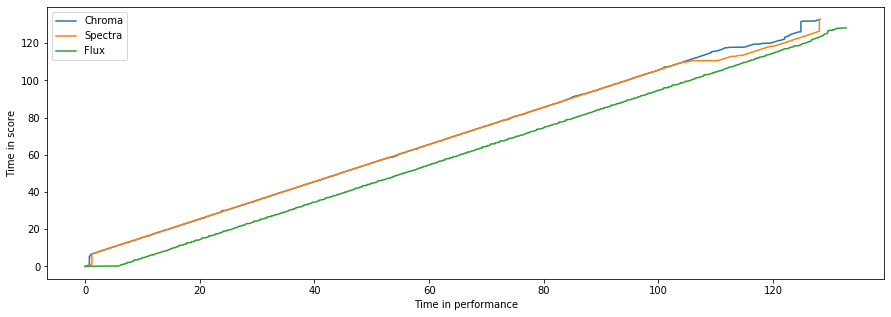

<Figure size 432x288 with 0 Axes>

In [103]:
#get alignment results
align_chroma=read_alignment(alignment_path+'/align_chroma.txt')
align_spectra=read_alignment(alignment_path+'/align_spectra.txt')
align_flux=read_alignment(alignment_path+'/align_flux.txt')
#plot both alignments
plot_alignments(align_chroma,align_spectra,align_flux)

(0.997, 1)

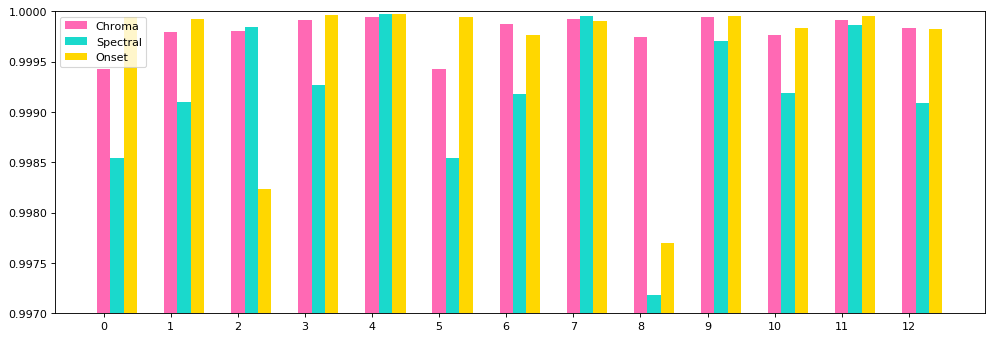

In [174]:
plt.figure(figsize=(15, 5), dpi=80)
x_data = pearson_merged.index
x_width = range(0,len(x_data))
x2_width = [i+0.2 for i in x_width]
x3_width = [i+0.4 for i in x_width]
y_data = pearson_merged['coef_corr_chroma']
y2_data = pearson_merged['coef_corr_spectra']
y3_data = pearson_merged['coef_corr_flux']
plt.bar(x_width,y_data,lw=1,fc='#FF69B4',width=0.2,label="Chroma")
plt.bar(x2_width,y2_data,lw=1,fc=(0.1,0.85,0.8),width=0.2,label="Spectral")
plt.bar(x3_width,y3_data,lw=1,fc='#FFD700',width=0.2,label="Onset")
plt.legend()
 
plt.xticks(x_data)
plt.ylim((0.997, 1))